# Stats Review : The Most Dangerous Equation

## Moivre's Equation

공식은 다음과 같다 ->  $SE =  \frac{\sigma}{\sqrt{n}}$

여기서 SE는 평균의 표준오차, $\sigma$는 표준편차, $n$은 표본의 크기를 나타냄.

이 공식을 모르는 것이 왜 위험한지에 대해 아래 데이터를 통해 확인해보자!

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

이 데이터는 ENUM(미국의 SAT와 유사한 브라질 표준 고등학교 성적 점수)을 3년간 수지반 데이터이다.

가장 성적이 좋은 학교를 보면 학생 수가 매우 적은 것을 확인할 수 있다

In [2]:
df = pd.read_csv('./data/enem_scores.csv')
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


In [4]:
np.mean(df.number_of_students)

139.52402414274795

아래 boxplot을 확인해보면, 상위 1%의 학교는 평균적으로 학생 수가 적음을 확인할 수 있다

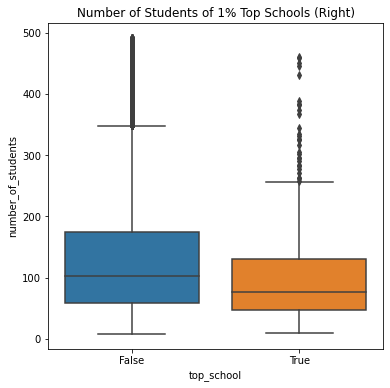

In [8]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

학생 수가 적은 학교들이 더 높은 학업 성취를 이끌어냄을 확인할 수 있다.
이는 직관적으로 보았을 때, 교사 한 명당 맡은 학생 수가 적을 때 교사가 각 학생에게 주의를 기울일 수 있기 때문이다.

하지만 이것이 왜 Moivre Equation과 무슨 연관이 있고 왜 위험한지 알아보자.

위에서 학생 수가 적은 학교들이 더 높은 학업 성취를 달성한다 -> 이 정보만을 기반으로 중요하고 비싼 결정을 하게 된다면 위험할 수 있다.

우리는 하위 1%의 학교들도 살펴보는 것을 잊고 있었다. 아래 산점도를 통해 확인해보자

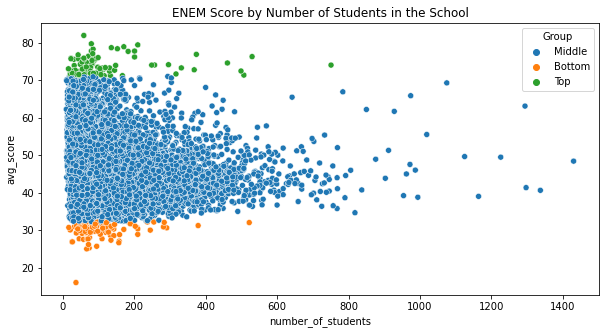

In [9]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

위의 산점도 그래프를 통해 확인해보면, 학생 수가 적은 학교들은 매우 높거나 매우 낮은 점수 분포를 보여준다.

Moivre 공식은 정보의 실재화와 데이터 기록형태는 항상 정확하지는 않다는 기본적인 사실에 대해서 이야기 한다.

불확실성을 계산하는 방법 중 하나는 ***분산의 추정량***을 구하는 것이다.

분산은 중심과 가장 가까이 있을 것 같은 값으로부터 얼마나 떨어져 있는지 알려준다.

Moivre 공식을 살펴보면, 불확실성은 관측된 데이터가 클수록 줄어든다.

만일 많은 학생들이 학교에서 잘한다면, 우리는 좋은 학교라고 확신할 수 있다.
하지만 만일 우리가 10명중 8명의 학생만 잘한다고 한다면, 더 의구심을 가져야한다. 우연으로 인해 그 학교는 평균이상의 학생들이 다닐 가능성이 있기 때문이다.

위의 그래프에서는 이를 보여준다.

표본의 수가 작을 때, 우리의 추정치는 큰 분산을 갖는다. 또한 표본이 커질수록 분산이 줄어드는 것을 확인할 수 있다.

이러한 사실은 평균점수 이외에도 우리가 추정하고 싶은 ATE를 비롯한 그 어떤 요약통계에 대해서도 마찬가지이다.

# The Standard Error of Our Estimate

이 전 섹션에서 우리는 평균 처리 효과 $E[Y_{1}-Y_{0}]$를 처리 군과 대조 군 평균 간 차이 $E[Y|T=1] - E[Y|T=0]$으로 다뤘다. 

우리는 온라인 수업의 ATE를 동기부여 사례로 알아냈다. 
또한 우리는 온라인 수업은 학생들의 수행 점수가 대면 수업일 때 보다 5점 낮은 부정적인 효과도 봤다. 

이제 통계적으로 유의한지 확인해보자.
이를 위해 우리는 표준오차를 추정해야한다. 

우리는 이미 표본크기 n에 대해 알고 있다. 

표준오차의 추정치는 $\hat{\sigma} = \sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_{i}-\bar{x})^2}$ 이고,  $\bar{x}$는 x의 평균을 의미합니다. 

In [11]:
data = pd.read_csv('./data/online_classroom.csv')

In [13]:
data.head()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000


In [27]:
online = data[data['format_ol']==1]['falsexam']
face_to_face = data[(data['format_ol']==0) & (data['format_blended']==0)]['falsexam']

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319104


# Confidence Intervals

추정치에 대한 표준오차는 확신에 대한 치수이다.

학생 점수가 평균 74, 표준편차 2인 정규분포를 따른다고 가정해보자.

이 분포로부터 10,000번의 실험을 해보자.
한 번의 실험에서 500의 표본을 얻자.

이것을 히스토그램으로 그려보면 실험에 대한 평균이 위의 가정에서 말한 평균 근처로 분포됨을 확인할 수 있다.

어떠한 실험 표본은 가정된 평균에 비해 작을 수도 있고 클 수도 있다



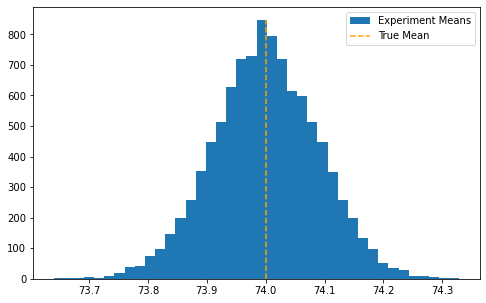

In [31]:
true_mean = 74
true_std = 2

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend()

우리는 평균들의 평균에 대해 이야기하고 있는 것을 기억하자!

우리는 표준오차를 통해 우리는 평균이 95% 포함되도록 구간을 만들 수 있다.

현실 세계에서 우리는 다양한 데이터 셋을 통해 같은 실험에 대해 여러번 실험할 수 없다. 

하지만 우리는 **신뢰구간**을 만들 수 있다. 

신뢰구간은 확률이 더해져서 구해지고, 가장 일반적인 구간은 95%이다. 

신뢰구간을 계산하기 위해서 우리는 **중심극한정리**(central limit theorem)를 이용한다. 

중심극한정리는 실험들의 **평균들이 정규분포를 따른다는 것**

우리는 통계학적 이론에서 정규분포 질량의 95%는 평균 위와 아래의 2 표준편차 사이에 있다는 것을 알고 있다. (정확하게는 1.96이지만 편의상 2)

![normal_density](./data/img/stats-review/normal_dist.jpeg)

평균의 표준오차는 실험 평균의 분포에 대한 추정치 역할을 한다. 

따라서 실험평균에서 표준오차에서 2(실제로는1.96)을 곱한 값을 빼고 더하면 신뢰구간을 구할 수 있다


In [32]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


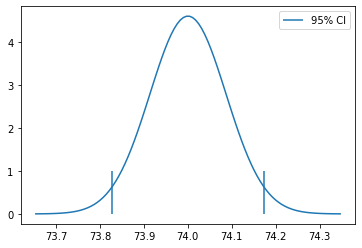

In [33]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

당연히 우리는 95% 신뢰구간으로 제한할 필요는 없다. 

우리는 표준편차를 곱하는데 필요한 것을 찾아 정규 분포의 질량의 99% 포함하는 신뢰구간도 만들 수 있다.

파이썬의 ppf 함수는 누적 분포 함수의 역함수를 알려준다.

95% 신뢰구간을 찾기 위해 표준오차 2를 곱하는 대신에, 99% 신뢰구간을 만들 z를 곱할 것.

따라서 ppf(0.5)는 정규분포 질량의 50%가 0 아래 있음을 나타내는 0을 나타낼 것. 

같은 방법으로 우리가 99.5%를 넣으면 분포 질량의 99.5%가 z값 아래 형성되도록 만드는 z를 구할 것. 

다시 말해 분포 질량의 0.5%는 z값보다 크다.

In [34]:
from scipy import stats
z = stats.norm.ppf(.995)

print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

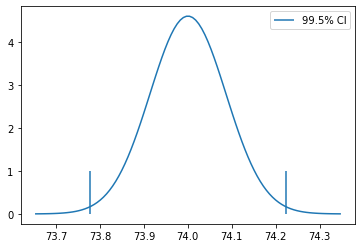

In [36]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99.5% CI")
plt.legend()
plt.show()

다시 데이터로 돌아와보자.

온라인수업과 대면수업 각각의 신뢰구간을 만들 수 있다

In [37]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206948, 80.29218687459712)


집단 간의 95%의 신뢰구간이 겹치지 않는다.

대면 수업의 신뢰구간의 하한이 온라인 수업의 신뢰구간의 상한보다 높다.

이는 대면수업의 실제 평균값이 온라인수업의 실제 평균값보다 높다는 결과가 우연적이지 않음을 보여준다.

다시 말해 대면수업에서 온라인 수업으로 전환할 경우, 학업성취에 대한 유의한 인과적 감소를 주장할 수 있다.

요약하면, ***신뢰구간은 추정치에 대한 불확실성을 배치하는 방법***이다.


표본이 작을수록, 표준오차는 커지고 신뢰구간은 넓어진다. 

표준오차와 신뢰구간을 계산하는 것은 쉽기 때문에, 신뢰 구간이 부족하다는 것은 나쁜 의도가 있거나 단순히 지식이 부족하다는 의미이다. 

마지막으로, 불확실성에 대한 지표가 없다면 항상 의심해야 한다.

![img](data/img/stats-review/ci_xkcd.png)




# Hypothesis Testing

불확실성을 표현하는 또 다른 방법은 가설검정!

평균간의 차이가 통계학적으로 0(혹은 다른 값) 과 다른가?!

독립정규분포 2개의 합과 차는 정규분포이다!

평균의 결과는 두 분포의 합과 차인 반면, 분산의 결과는 분산의 합이다.

$N(\mu_{1}, \sigma_{1}^2) - N(\mu_{2}, \sigma_{2}^2) = N(\mu_{1} - \mu_{2}, \sigma_{1}^2 + \sigma_{2}^2)$  

$N(\mu_{1}, \sigma_{1}^2) + N(\mu_{2}, \sigma_{2}^2) = N(\mu_{1} + \mu_{2}, \sigma_{1}^2 + \sigma_{2}^2)$  


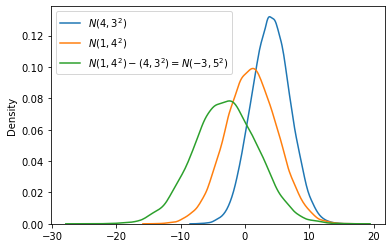

In [38]:
np.random.seed(123)

# 평균 4, 표준편차 3인 정규분포
n1 = np.random.normal(4, 3, 30000)
# 평균 1, 표준편차 4인 정규분포
n2 = np.random.normal(1, 4, 30000)

# 분포의 차
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

만일 우리가 두 집단들의 분포에서 평균을 뺀다면, 우리는 3번째 분포를 얻을 수 있다. 

이 최종 분포의 평균은 평균들 간 차이이고, 표준편차는 표준편차들의 합의 제곱근이다. 

$\mu_{diff} = \mu_{1} - \mu_{2}$  


$SE_{diff} = \sqrt{SE_{1} + SE_{2}} = \sqrt{\frac{\sigma_{1}^2}{n_{1}} + \frac{\sigma_{2}^2}{n_{2}}}$  

다시 데이터로 돌아가서, 차이에 대한 분포와 95% 신뢰구간을 만들어보자.

In [39]:
diff_mu = online.mean() - face_to_face.mean()

diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363357, -1.4480327880904964)


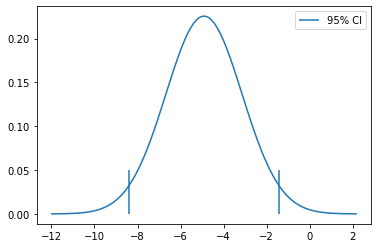

In [40]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)

y = stats.norm.pdf(x, diff_mu, diff_se)

plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

위의 결과를 보면, 온라인 집단과 대면 집단의 차이가 -8.37에서 -1.44 사이에 있는 것이 95% 신뢰할 수 있다고 할 수 있다.

우리는 평균 간 차이에 대한 표준오차를 나누어서 z통계량을 만들 수 있다.

$z = \frac{\mu_{diff}-H_{0}}{SE_{diff}} = \frac{(\mu_{1}-\mu_{2})}{\sqrt{\frac{\sigma_{1}^2}{n_{1}} + \frac{\sigma_{2}^2}{n_{2}}}}$  

$H_{0}$는 우리가 차이를 검정하고 싶은 값.

z통계량은 관측된 차이가 얼마나 극단적인지 측정해준다. 

우리는 평균의 차이가 0과 통계적으로 다르다는 가설을 검정하기 위해 모순을 이용할 것.

우리는 반대(차이가 0이다)를 참으로 가정할 것 -> 이를 귀무가설 혹은 $H_{0}$으로 표현. 

그리고 "만일 진정한 차이가 0이라면 우리는 이런 차이를 관찰할 가능성이 있을까?" 질문한다. 

이 질문을 통계학적 수학 용어로 z통계량이 0에서 얼마나 멀리 있는지 확인하는 것으로 변환할 수 있다. 

귀무가설 하에, z통계량은 표준 정규 분포를 따른다. 

따라서 만일 차이가 정말 0이라면, 우리는 z통계량이 평균적으로 95%의 확률로 2 표준편차 내에 확인할 수 있습니다. z가 2 표준편차보다 높거나 낮으면, 95% 신뢰도로 귀무가설을 기각할 수 있다. 


In [41]:
z = diff_mu / diff_se

print(z)

-2.7792810791031064


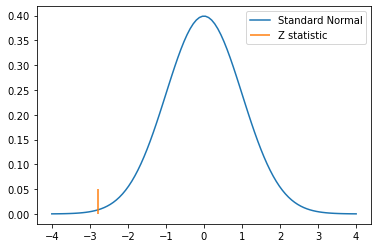

In [42]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

꽤 극단적인 값으로 보인다. 

실제로 2보다 큰데, 이는 집단 간 차이가 없다면 우리가 이런 극단적인 값을 볼 확률이 5% 미만을 의미. 

이는 또한 대면 수업에서 온라인 수업으로 전환하는 것이 통계적으로 유의미한 학업 성취도를 떨어뜨린다는 결론을 내리게 한다.

가설검정의 마지막 흥미로운 점은 처리된 집단과 처리되지 않은 집단의 95% 신뢰구간이 겹치는지 확인하는 것보다 덜 보수적이라는 점이다. 

다시 말해 만일 두 집단 간 신뢰구간이 겹친다 하더라도 통계적으로 유의할 수 있다. 

예를 들어 대면 집단이 평균 80점에, 표준오차 4, 온라인 집단이 평균 71점에 표준오차 2를 받았다고 가정해보자.

In [43]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


두 집단에 대해 신뢰구간을 만들면 겹친다. 

온라인 집단의 상한은 74.92이고 대면 집단의 하한은 72.16 이다. 

그러나 집단 간 차이에 대한 95% 신뢰구간을 계산하면 0이 포함되지 않는다. 개별 신뢰구간이 겹치더라도 여전히 통계학적으로 0과 다를 수 있다.


# P-values

위에서 온라인 집단과 대면 집단의 차이가 실제로 0이라면 우리가 이러한 극단적인 값을 관찰할 확률은 5% 미만이었다. 

하지만 우리가 그 가능성을 정확히 예측할 수 있을까? 우리가 이러한 극단적인 값을 관찰할 가능성이 얼마나 될까?

***p-value는 귀무가설이 올바르다고 가정할 때, 검정 중에 실제 관찰될 수 있는 가장 극단적인 검정결과를 얻을 확률이다***

    -> 즉, 귀무가설이 참이라는 가정하에 p값은 그러한 데이터를 볼 확률, 귀무가설이 참일 경우 측정값을 볼 가능성이 얼마나 낮은지를 측정하는 것
    

이는 귀무가설이 참일 확률과 혼동된다. 여기서 차이점을 주의하자! 

p값은 $P(H_{0}|data)$가 아니라 $P(data|H_{0})$이다.

p값을 구하려면, z통계량 전후에 표준 정규분포 면적을 계산해야한다. 

누적 표준 정규분포에 z통계량을 넣으면 계산 가능하다. 




In [44]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835564706


p값은 95% 혹은 99%와 같은 신뢰수준을 지정할 필요가 없다. 

하지만 p값에서 하나를 보고자 하는 경우 어떤 신뢰 수준에서 우리의 검정이 합격 혹은 불합격인지 정확히 알 수 있다. 

예를 들어 p값이 0.0027이라면, 유의수준이 0.2%임을 알 수 있다. 

따라서 95% 신뢰구간과 99% 신뢰구간에서는 0이 포함되지 않지만, 99.9% 신뢰구간에서는 포함된다. 

이는 만일 차이가 0이라면 이 극단적인 z통계량을 관측할 확률이 0.2%임을 의미한다.

In [45]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.37634655308288, -1.4480964433709733)
99% CI: (-9.464853535264012, -0.3595894611898425)
99.9% CI: (-10.72804065824553, 0.9035976617916743)


# key ideas

이번 챕터에서 Moivre의 공식을 아는 것이 얼마나 중요한지 보았고, 그것이 우리 추정치에 어느정도 확신이 되는지 알기 위해 사용했다. 

우리는 온라인 수업이 대면 수업에 비해 학업성취도 저하를 유발하는 것을 알아냈다. 

우리는 또한 통계학적으로 유의한 결과임을 확인했다. 

우리는 두 집단의 평균 신뢰구간을 비교하고, 차이에 대한 신뢰구간을 살펴보고, 가설검정을 수행했고 p값을 확인했다. 

단일 A/B 테스트 비교 함수를 만들어보자

In [46]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.5474845833333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.7792810791031064
P-Value 0.0027239680835564706


위 함수는 충분히 일반적이기 때문에, 다른 귀무가설 검정도 할 수 있다. 

ex) 온라인과 대면 수업의 효과 차이가 -1인지 기각할 수 있을까?

우리가 얻는 결과를 통해 우리는 95% 신뢰도를 통해 차이가 -1보다 유의하다고 할 수 있지만 99% 신뢰도로는 할 수 없다.

In [47]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.5474845833333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.2134920404560723
P-Value 0.013431870694630667
